# Read and plot SMAP data

## Overview

This has become an overly long notebook.  It was started to demonstrate some more _pythonistic_ streamlined workflows than we show in the SMAP tutorials for accessing, loading and plotting SMAP L3 data.  However, what should have been a short and simple demonstration of workflows became an exploration of the shortcomings of the L3 SMAP HDF5 files and workarounds to deal with them.  What follows is a hybrid of a tutorial, critique and suggested improvements.  I summarize the problems with the data set in this overview section.  Please see the code and plots below for examples.

The tutorials use the SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 8 (SPL3SMP, DOI:10.5067/OMHVSRGFX38O).

[Data set landing page](https://nsidc.org/data/spl3smp/versions/8)  
[User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf)

### Problems with the L3 SMAP Data

This list is not exhaustive.  It is informed by trying to describe workflows to open, read and plot the data contained in the files using current, standard tools in the geospatial python stack.  I suspect that the same problems and frustrations would be encountered if other software tools and programming languages were used.

The critique is also inspired by the belief that self-desribing file formats, conventions such as CF and COARDS, along with software tools designed to take advantage of these file formats and conventions, are there to make the working with data simple, allow scientists to start analysis sooner.  Ad-hoc file structures and incomplete (or inaccurate) metadata _"break"_ these tools, workflows.  Often the _forensic investigations_ required to track down the necessary information to "fix" problems introduced by non-conforming files is time consuming.  The following quote from the CF Conventions makes this point well.

>The purpose of the CF conventions is to require conforming datasets to contain sufficient metadata that they are self-describing in the sense that each variable in the file has an associated description of what it represents, including physical units if appropriate, and that each value can be located in space (relative to earth-based coordinates) and time.
>
>An important benefit of a convention is that it enables software tools to display data and perform operations on specified subsets of the data with minimal user intervention. It is possible to provide the metadata describing how a field is located in time and space in many different ways that a human would immediately recognize as equivalent. The purpose in restricting how the metadata is represented is to make it practical to write software that allows a machine to parse that metadata and to automatically associate each data value with its location in time and space. It is equally important that the metadata be easy for human users to write and to understand.

1.  **The HDF5 files do not contain sufficient information for the data to be geolocatable**.  The data are in a projected coordinate reference system (CRS) - EASE-Grid 2.0 - on a 406 x 964 grid with a 36 km grid cell height and width.  Although `latitude` and `longitude` 2D grids are included as Datasets, these grids are masked, so that coordinates are not available for all grid cells.  Coordinate grids **should not** have missing values.  Furthermore, standard tools in the Geoscience stack, such as `xarray`, do not allow coordinate variables to have missing data in accordance with conventions such as CF and COARDS.
2.  The data have a projected CRS, the projected coordinates should be included in the file.  These would be vectors containing `x` and `y` in meters.
3.  There are no named dimensions.  Standard tools (and humans) have no way to associate dimension variables (dimension scales in HDF5 terms) with data variables.
4.  There is no information about the CRS contained in the file.  It may be in the xml but modern tools expect to find it as a variable.  It should be included at least as a WKT string and an EPSG code.
5.  The names of Datasets have an inconsistent naming convention.  Datasets in the `Soil_Moisture_Retrieval_Data_PM` Group have the suffix `_pm`.  Datasets in the `Soil_Moisture_Retrieval_Data_AM` group do not.  This makes programmatic workflows more complicated because users have to "code around" the differences in file names.  For example: `if spass == 'PM': filename = f"{variable}_{spass.lower()} \\ else: filename = variable` instead of `filename = f"{variable}_{spass.lower()}"`.
6.  Some of the attribute data is incorrect.  See the `landcover_class` for an example.  The `long_name` attribute is used to describe the dimensions.  This is the wrong place to describe this.  `long_name` should be reserved for the name of the variables.  If named dimensions had been created there would be no need to describe the dimensions.  Moreover, dimensions are listed as longitude, latitude and IGBP land cover type.  Longitude and latitude cannot be dimensions.  The data arrays are in projected coordinates.  Longitude and latitude are 2D arrays and, therefore, it is impossible to assign them as dimensions, which by definition, are 1D vectors.  The dimensions should be x and y or easting and northing. 
  


In [1]:
from pathlib import Path

import earthaccess
import h5py
import rioxarray
import xarray as xr
import numpy as np

from affine import Affine
from pyproj import CRS

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pprint import pprint

/home/apbarret/anaconda3/envs/nsidc_data_cookbook/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Search for SMAP data

We will use `earthaccess` to search for SMAP Level 3 files for March 2017.  The first step is to authenticate using `earthaccess.login`.  We can then use `search_data` to search for data.

In [2]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 09/19/2023
Using .netrc file for EDL


In [3]:
results = earthaccess.search_data(
    short_name = 'SPL3SMP',
    version = '008',
    cloud_hosted = False,
    temporal = ('2017-03-01','2017-03-31')
)

Granules found: 31


## Download files

If you haven't already, we'll download the files to a local directory.  This is defined in the `DOWNLOAD_PATH` constant.  In this example, we'll use the `Path` object from the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package to build a path to a directory `smap_data` under the current working directory.  `Path` objects have methods to return the current working directory `.cwd()`, make directories `.mkdir()`, and search using globbing `.glob()`.

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to download files to a different directory change the cell below to  

```
DOWNLOAD_PATH = Path("path-to-download-directory")
```
</div>

`earthaccess.download` checks if the files already exist in the local download directory.

In [4]:
DOWNLOAD_PATH = Path.cwd() / "smap_data"
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)  # creates parents if they don't exist and fails silently if path exists

smap_files = earthaccess.download(results, DOWNLOAD_PATH)

 Getting 31 granules, approx download size: 0.93 GB


QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 6042.26it/s]


File SMAP_L3_SM_P_20170301_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170302_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170303_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170305_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170304_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170308_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170309_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170306_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170307_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170311_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170312_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170310_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170313_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170316_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170317_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170318_R18290_001.h5 already downloaded
File SMAP_L3_SM_P_20170315_R18290_001.h5

PROCESSING TASKS | : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 85598.04it/s]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 211420.20it/s]


I then use `.glob('*.h5')` to get a list of SMAP files in the `DOWNLOAD_PATH`

In [5]:
smap_files = list(DOWNLOAD_PATH.glob('*.h5'))  # .glob() returns a generator list() turn it into a list 
smap_files

[PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170319_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170330_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170313_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170324_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170328_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170326_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170305_R18290_001.h5'),
 PosixPath('/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data

## Read data from HDF5 file using `h5py`

HDF5 files are hierarchical data structures that consist of _Groups_ and _Datasets_.  Groups contain sub-groups and Datasets.  Datasets are equivalent to Variables in NetCDF files.  Both Groups and Datasets can have attributes.  Datasets are multidimensional arrays similar to numpy arrays and have `shape`, `ndim`, `dtype` attributes the same as numpy arrays.

The best way to explore an HDF5 file is to use a "viewer".  [MyHDF5](https://myhdf5.hdfgroup.org/) is one such tool.  You can upload a file from your local machine or point to a URL for a file.

We open an HDF5 file using `h5py.File`, which returns a file object.  This file object is also the _root_ group for the file. 

In [6]:
root = h5py.File(smap_files[0], 'r')
root

<HDF5 file "SMAP_L3_SM_P_20170319_R18290_001.h5" (mode r)>

_Add examples of accessing Groups by path, accessing attributes and data arrays, as well as dimensions_

A HDF5 `Dataset` can be accessed using a similar syntax to how you would access a file on your hard drive.  For example we can access the `soil_moisture` data set for the AM pass with the following command.  

In [7]:
root['Soil_Moisture_Retrieval_Data_AM/soil_moisture']

<HDF5 dataset "soil_moisture": shape (406, 964), type "<f4">

We can see that this is a data array with shape 406 x 964 containing 32 bit floating point numbers (`<f4` indicates 4-byte float).  This information can also be accessed using the `name`, `shape`, `ndim` and `dtype` attributes of the `Dataset`

In [8]:
print(root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].name)
print(root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].shape)
print(root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].ndim)
print(root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].dtype)

/Soil_Moisture_Retrieval_Data_AM/soil_moisture
(406, 964)
2
float32


The `soil_moisture` `Dataset` has two dimensions with sizes 406 and 964.  HDF5 allows dimensions to have a name and have an attached scale.  For geoscience data, the logical scales attached to a dimension are coordinates.  This not only provides context for the data, making it richer and more useable, it also georeferences the data in space.  Without coordinates the grids are not locatable on Earth.

Unfortunately, none of the Datasets in the L3 SMAP soil moisture files have named dimensions or attached scales.

In [9]:
for k, v in root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].dims[0].items():
    print(f"{k}: {v}")

To access the data array and write it to a variable, we use the following syntax.  Even though the data is a two dimensional array, we can get all the data with `[:]`. 

In [10]:
data = root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][:]
data

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

To access a slice of the data array, we can use the normal syntax for slicing a numpy array.

In [11]:
root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'][0:4, :]

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

The `Dataset` attributes can be accessed using the `attr` attribute.  This returns a dictionary-like object that can be accessed using `keys`, `values` and `items` methods, along with `h5py` package specific methods.  Here, we use a `for` loop and `items` to iterate through and print the key:value pairs.

<div class="alert alert-block alert-info">
<b>Tip:</b> The non-numerical data attributes are byte strings, these can be converted to strings using `decode`
</div>

In [12]:
for key, value in root['Soil_Moisture_Retrieval_Data_AM/soil_moisture'].attrs.items():
    print(f"{key}: {value}")

_FillValue: -9999.0
coordinates: b'/Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude'
long_name: b'Representative DCA soil moisture measurement for the Earth based grid cell.'
units: b'cm**3/cm**3'
valid_max: 0.5
valid_min: 0.019999999552965164


## _Optional_:  An alternative way to access Groups and Datasets

An alternative way to list `Groups` and `Datasets` in the file is to use the `visit` and `visititems` methods.  Both these methods iterate over the objects in a file. They take a function name as an argument.  `visit` takes a function with the form:

```
myfunc(<member name>)
```

This function can be used to return a list of all Groups and Datasets in the file.  In the example below we create an empty list and then pass the `list.append` method, which is a function, to visit.

In [13]:
list_of_names = []
root.visit(list_of_names.append)
list_of_names

['Metadata',
 'Metadata/AcquisitionInformation',
 'Metadata/AcquisitionInformation/platform',
 'Metadata/AcquisitionInformation/platformDocument',
 'Metadata/AcquisitionInformation/radar',
 'Metadata/AcquisitionInformation/radarDocument',
 'Metadata/AcquisitionInformation/radiometer',
 'Metadata/AcquisitionInformation/radiometerDocument',
 'Metadata/DataQuality',
 'Metadata/DataQuality/CompletenessOmission',
 'Metadata/DataQuality/DomainConsistency',
 'Metadata/DatasetIdentification',
 'Metadata/Extent',
 'Metadata/GridSpatialRepresentation',
 'Metadata/GridSpatialRepresentation/Column',
 'Metadata/GridSpatialRepresentation/GridDefinition',
 'Metadata/GridSpatialRepresentation/GridDefinitionDocument',
 'Metadata/GridSpatialRepresentation/Row',
 'Metadata/Lineage',
 'Metadata/Lineage/EASEGRID_LON_M',
 'Metadata/Lineage/InputConfiguration',
 'Metadata/Lineage/L2_SM_P',
 'Metadata/Lineage/MetadataConfiguration',
 'Metadata/Lineage/OutputConfiguration',
 'Metadata/Lineage/RunConfiguration'

We can also write a function to look for members with albedo in the name. 

In [14]:
list_of_names = []
def get_albedo(name):
    if 'albedo' in name.lower():
        list_of_names.append(name)

root.visit(get_albedo)
list_of_names

['Soil_Moisture_Retrieval_Data_AM/albedo',
 'Soil_Moisture_Retrieval_Data_AM/albedo_scah',
 'Soil_Moisture_Retrieval_Data_AM/albedo_scav',
 'Soil_Moisture_Retrieval_Data_PM/albedo_dca_pm',
 'Soil_Moisture_Retrieval_Data_PM/albedo_scah_pm',
 'Soil_Moisture_Retrieval_Data_PM/albedo_scav_pm']

`visititems` not only takes a function with the member name but also the actual Group or Dataset object.

```
myfunc(name, obj)
```

we can use this to get particular variables or do some form of processing based on whether the object is a Group or a Dataset.

In the example below, we will extract the data arrays for albedo variables for the AM pass.  I first look for `AM` in the name and then check if the name contains `albedo` as in the `visit` example above.  I only want `Datasets`.  `Groups` do not contain data arrays.  To do this, I use the `isinstance` function that is part of the standard library.  `isinstance` take `obj` as an argument and checks to see if it is of the type `h5py.Dataset`.

If all three of these conditions are `True`, I then want to write the variables to a dictionary.  I want to use the name of the `Dataset` as the key for each data array.  I can split the `name` string on the `/` character and take the last element of the list that is returned.  To assign the data array and not the `Dataset` object, I use the `[:]` syntax.  

In [15]:
dict_of_vars = {}
def get_vars(name, obj):
    if ('AM' in name) & ('albedo' in name) & isinstance(obj, h5py.Dataset):
        dict_of_vars[name.split('/')[-1]] = obj[:]

root.visititems(get_vars)
dict_of_vars

{'albedo': array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        ...,
        [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        [ 2.8333332e-02,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  2.9999997e-02]], dtype=float32),
 'albedo_scah': array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
        [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
         -9.9990000e+03, -9.9990000e+03, -9

The `h5py.File` opens the file.  The file needs to be closed, otherwise it remains in memory.  If you are reading multiple files, this could lead to memory problems.

In [16]:
root.close()

## Creating a georeferenced `xarray.Dataset` for a subset of variables from an HDF5 SMAP file

Fully georeferenced data sets are required for Earth science analysis workflows.  This may be as simple as plotting a map.  You may want to transform the data so it can be used with another data set, or you may want to perform some geospatial subsetting.

Unfortunately, the SMAP HDF5 files do not contain sufficient information to geolocate data on the Earth surface.  This is is the case both for using the data with software tools to display or manipulate the data, and for humans trying to understand the data.  The following example shows:

1. how to read a subset of `Datasets` (variables) from the HDF5 file and create a geospatially aware `xarray.Dataset`;
2. how to mask missing data;
3. how to add coordinate information to the dataset;
4. how to add a coordinate reference system information the dataset.

`xarray` can read a group from an HDF5 file.  In the following example, we read the `Soil_Moisture_Retrieval_Data_AM` group.

In [17]:
gds = xr.open_dataset(smap_files[0], group='Soil_Moisture_Retrieval_Data_AM')  #, decode_coords='all', decode_cf=True)
gds

<xarray.Dataset>
Dimensions:                      (phony_dim_0: 406, phony_dim_1: 964,
                                  phony_dim_2: 3)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/53)
    EASE_column_index            (phony_dim_0, phony_dim_1) float32 ...
    EASE_row_index               (phony_dim_0, phony_dim_1) float32 ...
    albedo                       (phony_dim_0, phony_dim_1) float32 ...
    albedo_dca                   (phony_dim_0, phony_dim_1) float32 ...
    albedo_scah                  (phony_dim_0, phony_dim_1) float32 ...
    albedo_scav                  (phony_dim_0, phony_dim_1) float32 ...
    ...                           ...
    tb_v_uncorrected             (phony_dim_0, phony_dim_1) float32 ...
    vegetation_opacity           (phony_dim_0, phony_dim_1) float32 ...
    vegetation_opacity_dca       (phony_dim_0, phony_dim_1) float32 ...
    vegetation_opacity_scah      (phony_dim_0, phony_dim_1) float32 ...
    vegetation_opacity_scav      (phony_dim_0, phony_dim_1) float32 ...
    vegetation_water_content     (phony_dim_0, phony_dim_1) float32 ...

53 variables are loaded from `Soil_Moisture_Retrieval_Data_AM`.  However, we can immediately see some issues.  The dimensions are named `phony_dim_0`, `phony_dim_1`, and `phony_dim_2`, which is not much help.  This is because no dimensions are assigned to Datasets so `xarray` has to generate some dummy variables.  The same problem arises if the Python binding for HDF5 library, `h5py`, were used.
 
Let's change the names of the dimensions to something useful and meaningful.  The first thing is to figure out what the dimensions are.  This is more diffcult than is should be.  Some of the metadata is wrong.  Some is confusing.  The description of the `landcover_class` offers some information, albeit misleading, but it is a clue.

> An enumerated type that specifies the most common landcover class in the grid cell based on the IGBP landcover map. The array order is longitude (ascending), followed by latitude (descending), and followed by IGBP land cover type descending dominance (only the first three types are listed)

This description states that the dimensions of the landcover_class array are longitude, latitude and IGBP land cover class.  The data are in projected coordinates (EASE Grid 2.0) **so longitude and latitude cannot be dimensions**.  Longitude and latitude must be 2D arrays for a projected dataset.  However, x and y or easting and northing are likely candidates.  However, the 3rd dimension appears to be land cover class.  Plotting the `soil_moisture` variable also shows that `phony_dim_1` is the x-dimension and `phony_dim_0` is the y-dimension in cartesian coordinates.  So we'll rename the coordinates:

 - `phony_dim_0 --> y`
 - `phony_dim_1 --> x`
 - `phony_dim_2 --> igbp_class`

We can do this using `rename_dims`, which takes a dictionary as an argument, where keys are the old dimension name and values are the new dimension name.

In [18]:
gds = gds.rename_dims({'phony_dim_0': 'y', 'phony_dim_1': 'x', 'phony_dim_2': 'igbp_class'})
gds

<xarray.Dataset>
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Dimensions without coordinates: y, x, igbp_class
Data variables: (12/53)
    EASE_column_index            (y, x) float32 ...
    EASE_row_index               (y, x) float32 ...
    albedo                       (y, x) float32 ...
    albedo_dca                   (y, x) float32 ...
    albedo_scah                  (y, x) float32 ...
    albedo_scav                  (y, x) float32 ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 ...
    vegetation_opacity           (y, x) float32 ...
    vegetation_opacity_dca       (y, x) float32 ...
    vegetation_opacity_scah      (y, x) float32 ...
    vegetation_opacity_scav      (y, x) float32 ...
    vegetation_water_content     (y, x) float32 ...

Another issue is that there are no coordinate variables, again because the HDF5 file was not created with any.  Inspecting the variables, we see that there are two possible candidate coordinate variables: `latitude` and `longitude`.  So let's plot them.

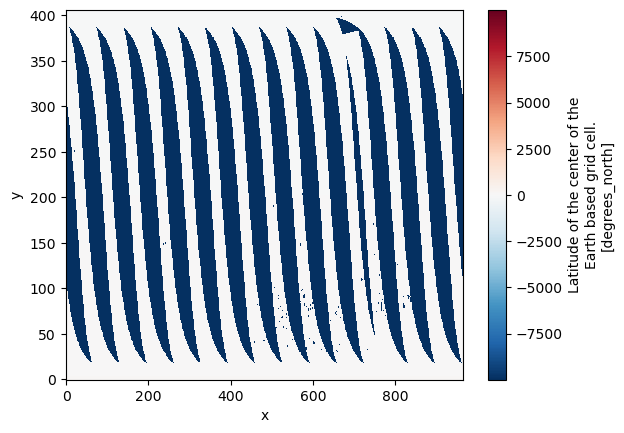

In [19]:
gds.latitude.plot()

In [20]:
print(gds.latitude.min(), gds.latitude.max())

<xarray.DataArray 'latitude' ()>
array(-9999.) <xarray.DataArray 'latitude' ()>
array(83.63197327)


If we plot both latitude and soil_moisture, we can see that latitude values have been masked with -9999. where there are no valid data values.  **This is not a good or sensible approach because latitude and longitude are coordinates.  As long as latitude and longitude values are between -90 and 90, and -180 and 180 (or 0 and 360), they are valid coordinates.  Under NetCDF and CF conventions, coordinate values should not have missing values.  We also need coordinates for all grid cells for plotting and other operations.** 

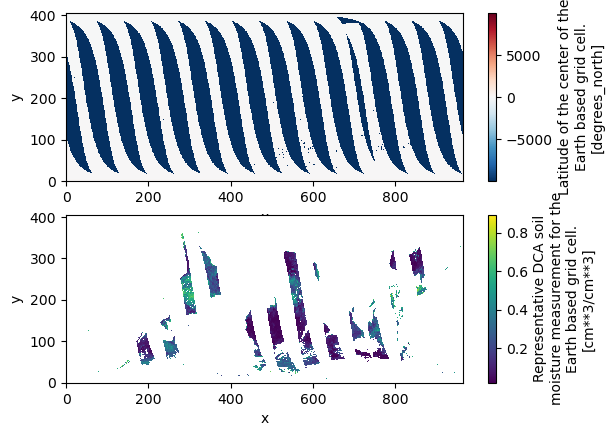

In [21]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0]);
gds.soil_moisture.plot(ax=ax[1])

Neither the plot of latitude nor the minimum and maximum values look as we would expect.  We expect latitude to be in the range of -90 to +90.  The maximum is actually in this range but the minimum is -9999., which is suspiciously like a `_FillData` or missing data value.  We would also expect the image to show a smooth field that only varies in the vertical direction, e.g. from -90. to 90. or some similar range.  Instead it shows a set of lozenges.

Let's set the `_FillValue` attribute for latitude to `-9999`.  In `xarray`, we have to use `where` to apply a mask everywhere a condition is not `True`.  Here we set the condition to be _not equal to -9999._  To save time and errors later, we also set the `encoding` entry for `fillvalue` to -9999.

<div class="alert alert-block alert-warning">
`encoding` is a dictionary of parameters that defines how data are "encoded" in the file.  It includes information about how data are compressed, chunked, the _FillValue, and data type.  Saving the `encoding` is not strictly necessary unless you want to write the data to a new file.  We'll follow these steps here to demonstrate how to preserve the encoding data. 
</div>

In [22]:
print(gds.latitude.encoding)

{'zlib': True, 'szip': False, 'zstd': False, 'bzip2': False, 'blosc': False, 'shuffle': False, 'complevel': 2, 'fletcher32': False, 'contiguous': False, 'chunksizes': (1, 964), 'source': '/home/apbarret/src/NSIDC-Data-Cookbook/nsidc-data-cookbook/tutorials/smap_data/SMAP_L3_SM_P_20170319_R18290_001.h5', 'original_shape': (406, 964), 'dtype': dtype('float32')}


In [23]:
fillvalue = -9999.

# `where` does not preserve encoding, so we have to copy first
encoding = gds.latitude.encoding
# Apply fillvalue mask
gds['latitude'] = gds.latitude.where(gds.latitude != fillvalue)
# we copy the encoding back to DataArray
gds.latitude.encoding = encoding
# ...and update encoding to include fillvalue
gds.latitude.encoding['fillvalue'] = fillvalue

Now when we check the range of the latitude values, we see that the range is between -83.63... and 83.63... as we expect.

In [24]:
print(gds.latitude.min(), gds.latitude.max())

<xarray.DataArray 'latitude' ()>
array(-83.63197327) <xarray.DataArray 'latitude' ()>
array(83.63197327)


Plotting the data again, we see that latitude values are within the expected range but that hasn't solved the missing data problem.

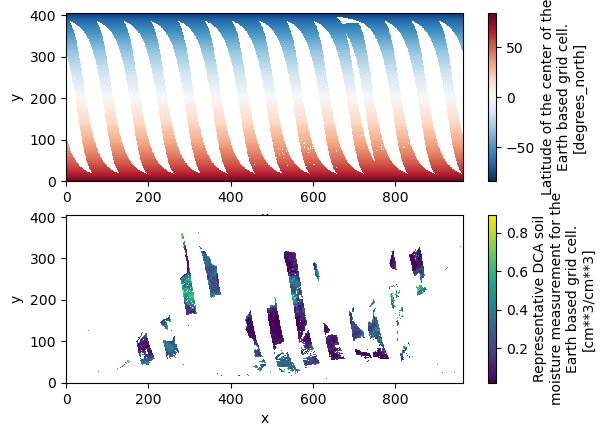

In [25]:
fig, ax = plt.subplots(2, 1)
gds.latitude.plot(ax=ax[0]);
gds.soil_moisture.plot(ax=ax[1])

#### Adding coordinates

There are no useful coordinate values.  If we plotted `longitude` we would see the same problem, and beside we need both latitude and longitude.  As noted above, the files do not include complete information about the coordinate reference system or the grid definition.  So we need to do some data sleuthing.

Tables 4 and 5 in the [User Guide](https://nsidc.org/sites/default/files/spl3smp-v008-userguide.pdf) provide geospatial information.  Further information on EASE Grids can be found on [A Guide to EASE Grids page](https://nsidc.org/data/user-resources/help-center/guide-ease-grids).

<div class="alert alert-block alert-warning">
<b>Note:</b> The ATBD for the L3 SMP data gives the data array dimensions as 406 x 963.
</div>



The CRS and grid definition are independent.  The CRS defines how projected coordinates, usually in meters, relate to geographic latitude and longitude.  The grid definition relates how image coordinates (columns and rows) map to the projected coordinates.  The Guide to EASE Grids has 8 grid definitions, ranging from 1 km to 36 km cell sizes, for the Global EASE-Grid 2.0 CRS (EPSG:9633).  We could define many more grid definitions.  For more information on CRS, map projections and grids see [_Link to be added_]().

In the [table](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-10) for the 36 km Global EASE-Grid 2.0 we are given the height and width of each grid cell, and the x and y coordinates of the upper-left corner of the upper-left grid cell.  We can see that the 36 km grid cell size is not exact.  In fact the value the table gives is not exact.  The actual value runs to 9 decimal places.  This is because the grid cell height and width of the global grid were defined so that an exact number of cells span the equator {@brodzik_ease}.  This is not necessary for polar grids.

<div class="alert alert-block alert-info">
<b>Tip:</b> Exact definitions of CRS, projection and grid parameters can be found in the Grid Parameter Definition (gpd) files in the [`mapxmaps` GitHub repository](https://github.com/nsidc/mapxmaps).  These gpd files have a somewhat esoteric format, so might take a little bit to understand.  It is important that the grid definition is exact because we cannot merge datasets if the coordinates do not match, even to the 9th decimal place.
</div>

In [26]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

The projected coordinates of a grid cell can be found using the following formulas:

$$
x = (grid\_cell\_width \times row) + x\_upper\_left\_corner
$$
$$
y = (grid\_cell\_height \times column) + y\_upper\_left\_corner)
$$

This equations assumes that the origin of the image coordinates start at row=0. and column=0. in the upper-left corner of the upper-left grid cell.  So the center of the upper-left grid cell is row=0.5 and column=0.5.  Adding 0.5 to row and column indices solves this problem.

We could write a function to return (x, y) coordinates for (column, row) image coordinates using the equations above.  Or we can use the `Affine` class from the `affine` package to define an affine matrix.  This is what we'll do below.  

In [27]:
transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)
transform

Affine(36032.220840584, 0.0, -17367530.4451615,
       0.0, -36032.220840584, 7314540.8306386)

This then allows us to calculate x and y coordinates from column and row indices using matrix multiplication.

In [28]:
transform * (964, 406)

(17367530.445161477, -7314540.830638505)

We'll define vectors for the row and column indices of the grid cell centers, and then use the `transform` matrix to get x and y coordinates.  These only need to be vectors as well because each column will have the same row indices and each row will have the same column indices. We'll use the `numpy.arange` function to do and start the range at 0.5 to offset the row and column indices for grid cell centers by 0.5.

In [29]:
nrows, ncolumns, nclass = gds.dims['y'], gds.dims['x'], gds.dims['igbp_class']  #data_vars['soil_moisture'][1].shape
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)  # Add attributes

We need to assign `x`, `y`, and `igbp_class` as coordinates.  This should be sufficient for plotting.  However, if we want to reproject the data we should define the CRS and spatial coordinates, and transform.  We do this using `rioxarray` accessors.

In [30]:
gds = gds.assign_coords(x=x, y=y, igbp_class=igbp_class)

gds.rio.write_crs(6933, grid_mapping_name='wgs84_easegrid2_global', inplace=True)
gds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)
gds.rio.write_coordinate_system(inplace=True)
gds.rio.write_transform(transform)
gds.rio.write_grid_mapping('wgs84_easegrid2_global', inplace=True)
gds

<xarray.Dataset>
Dimensions:                      (y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 -1.735e+07 -1.731e+07 ... 1.735e+07
  * y                            (y) float64 7.297e+06 7.26e+06 ... -7.297e+06
  * igbp_class                   (igbp_class) int64 0 1 2
    wgs84_easegrid2_global       int64 0
Data variables: (12/53)
    EASE_column_index            (y, x) float32 ...
    EASE_row_index               (y, x) float32 ...
    albedo                       (y, x) float32 ...
    albedo_dca                   (y, x) float32 ...
    albedo_scah                  (y, x) float32 ...
    albedo_scav                  (y, x) float32 ...
    ...                           ...
    tb_v_uncorrected             (y, x) float32 ...
    vegetation_opacity           (y, x) float32 ...
    vegetation_opacity_dca       (y, x) float32 ...
    vegetation_opacity_scah      (y, x) float32 ...
    vegetation_opacity_scav      (y, x) float32 ...
    vegetation_water_content     (y, x) float32 ...

In [31]:
print(gds.latitude.rio.grid_mapping)
print(gds.rio.bounds())

wgs84_easegrid2_global
(-17367530.4451615, -7314540.830638505, 17367530.445161473, 7314540.8306386)


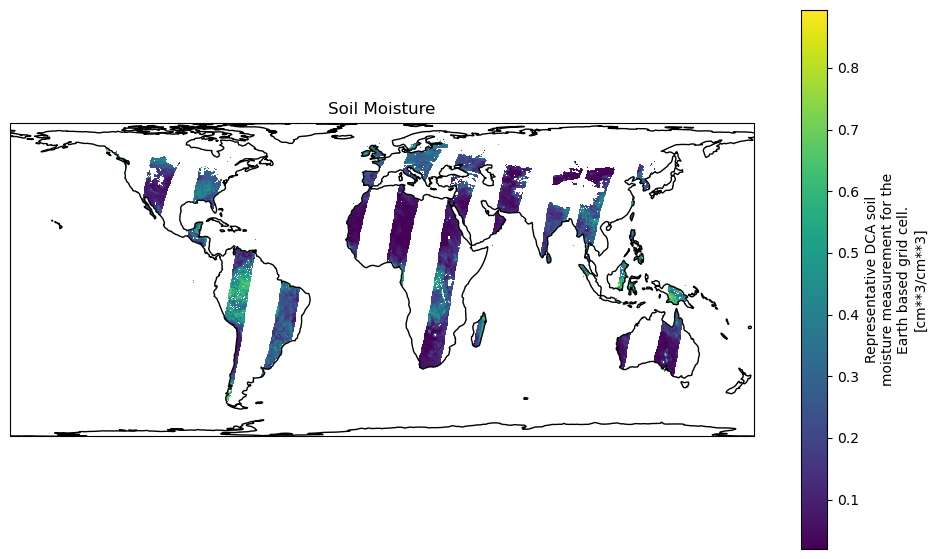

In [32]:
EASEGrid2 = ccrs.epsg(gds.rio.crs.to_epsg())

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection=EASEGrid2)

ax.coastlines()
gds.soil_moisture.plot(ax=ax,)
ax.set_title('Soil Moisture');

## Extra Stuff to be refined

In [ ]:
grid_mapping_name = "WGS84_NSIDC_EASEGrid_2.0_Global"
datasets = ['Soil_Moisture_Retrieval_Data_AM/soil_moisture', 'Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag']
data_vars = {}
dims = ['y', 'x']
with h5py.File(smap_files[0]) as root:
    for dataset in datasets:
        ds = root[dataset]
        path = ds.name
        name = path.split('/')[-1]
        attrs = {k: (v.decode('UTF-8') if hasattr(v, 'decode') else v) for k, v in dict(ds.attrs).items()}
        attrs['grid_mapping'] = grid_mapping_name  # Add so that dataset is CF-compliant and geoferenced
        data_vars[name] = (dims, ds[:], attrs)

data_vars
        

In [ ]:
plt.imshow(data_vars['soil_moisture'][1])

In [ ]:
data_vars['soil_moisture'][1].shape

In [ ]:
plt.pcolormesh(x, y, data_vars['soil_moisture'][1])

We also need to define the CRS.  We know that the CRS has the EPSG code 6933.  We can use `pyproj` to get the CRS definition.

Base on [CF-Conventions](http://cfconventions.org/cf-conventions/cf-conventions.html#grid-mappings-and-projections), we add the CRS as a variable with the same name as we used for the `grid_mapping` attribute of each data variable.  We define this variable as an integer.  The grid mapping information is then copied as attributes for that variable.  We use the `to_cf()` method of the `pyproj.CRS` object to do this.

In [ ]:
ds = xr.Dataset(data_vars, coords={'x': x, 'y': y})
ds

In [ ]:
ds.rio.write_crs(6933, inplace=True)

#ds[grid_mapping_name].attrs = crs.to_cf()

In [ ]:
ds =xr.decode_cf(ds)

In [ ]:
ds.soil_moisture.plot()